In [1]:
from pathlib import Path
import pandas as pd
from immloom import segm_preprocess, segm_filter, plot_segments, split_segments_sdir, plot_segments_color
from immloom import create_and_plot_graph
import os
from math import sqrt
from typing import List, Tuple, Dict, Set, Optional
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

n1 = 0
n2 = 1

data_dir = Path('../data/processed/dataset_01/patchwork_output/IGH/pairwise_alignments')


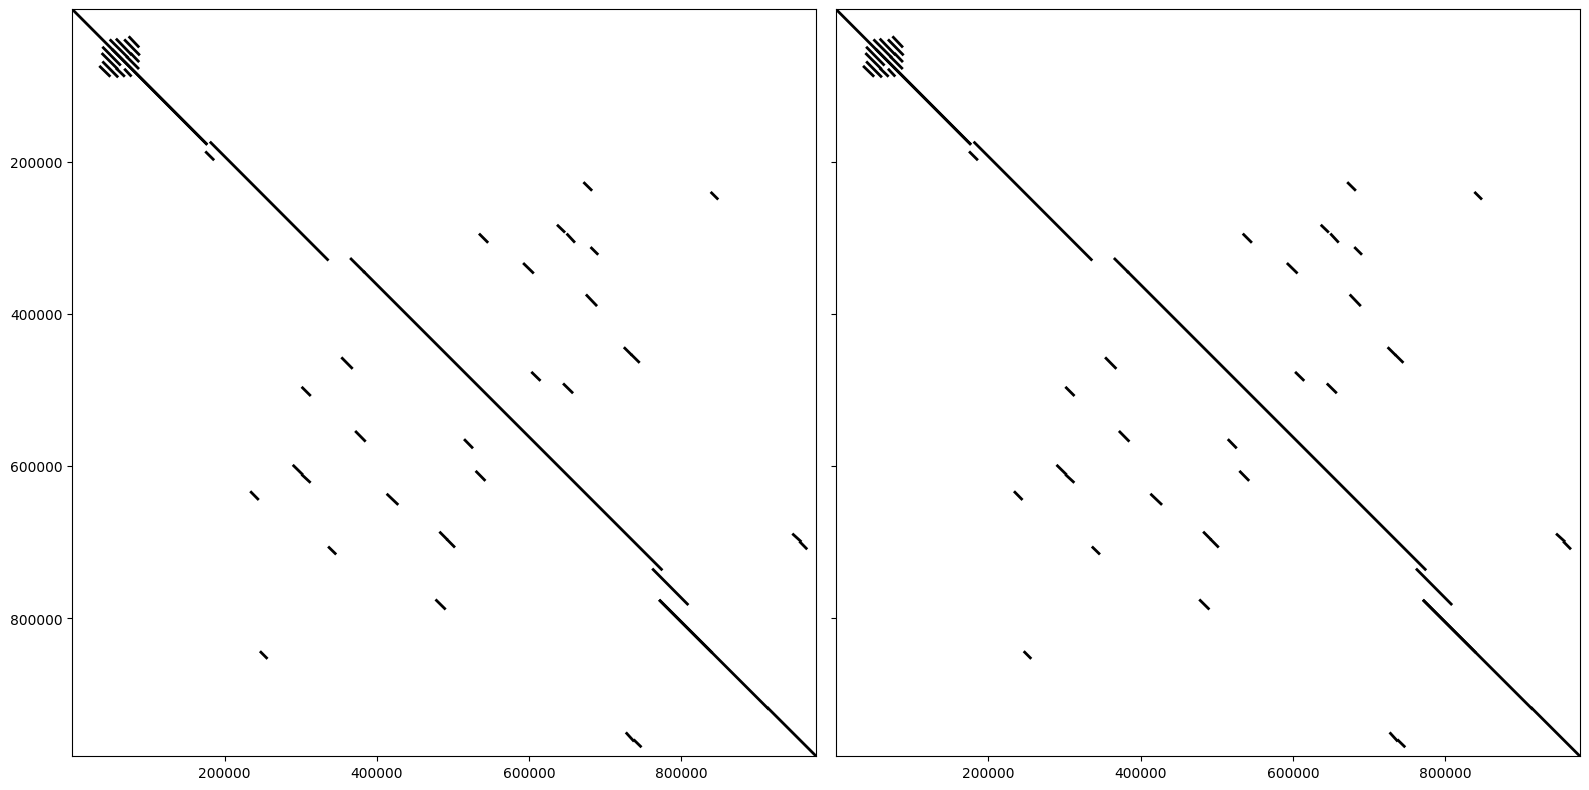

In [2]:
s_lst = os.listdir(data_dir)
s_lst = sorted([x[5:-4] for x in s_lst if x[:4]=='self'])

if n1!=n2:
    f_name = f'pair_{s_lst[n1]}_{s_lst[n2]}.tsv'
else:
    f_name = f'self_{s_lst[n1]}.tsv'

df = segm_preprocess(data_dir, f_name)
df1_all = segm_filter(df, pi=80.0, length=10000)
df1 = df1_all[df1_all.strand=='+']

plot_segments(df1_all, df1)

In [3]:
dfx = pd.read_csv(f'../immloom_out/self_{s_lst[n1]}/block.tsv', sep='\t')
dfy = pd.read_csv(f'../immloom_out/self_{s_lst[n2]}/block.tsv', sep='\t')

In [4]:
split_points = sorted(list(set(list(dfx.d1)+list(dfx.d2))))
df2 = split_segments_sdir(df1, split_points=split_points)

split_points = sorted(list(set(list(dfy.d1)+list(dfy.d2))))
df3 = split_segments_sdir(df2, split_points=split_points, sdir='horiz')

In [5]:
df3['in_x'] = df3.apply(
    lambda r: ((dfx['d1'] <= r['x1']) & (dfx['d2'] >= r['x2'])).any(),
    axis=1
)

df3['in_y'] = df3.apply(
    lambda r: ((dfy['d1'] <= r['y1']) & (dfy['d2'] >= r['y2'])).any(),
    axis=1
)

df3 = df3[df3.length>=2000]

(<Figure size 1000x800 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

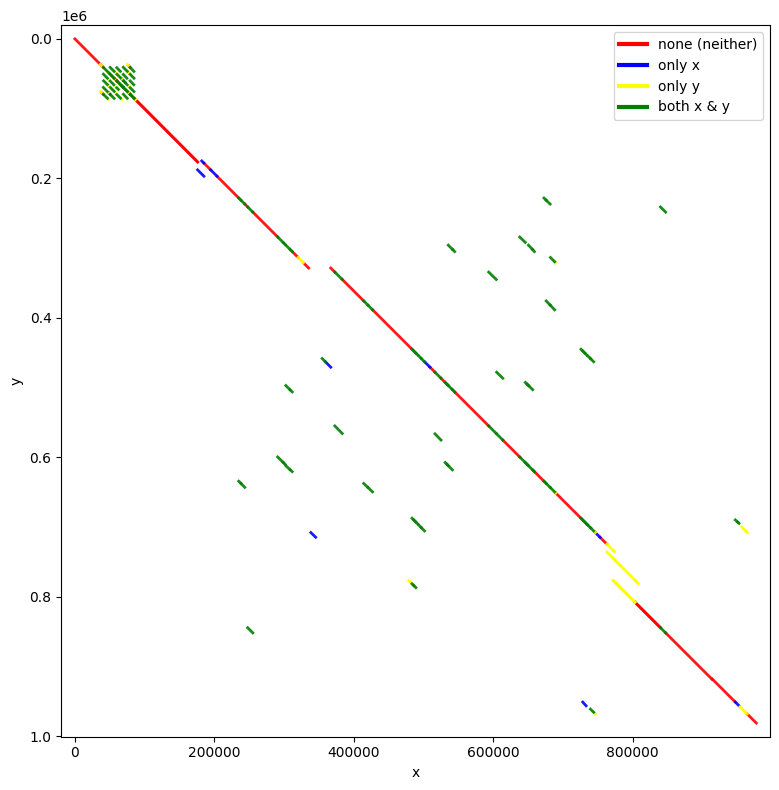

In [6]:
plot_segments_color(df3)

In [7]:
print(df3[df3.in_x & df3.in_y].length.sum()/df3.length.sum())
print(df3[df3.in_x & ~df3.in_y].length.sum()/df3.length.sum())
print(df3[~df3.in_x & df3.in_y].length.sum()/df3.length.sum())
print(df3[~df3.in_x & ~df3.in_y].length.sum()/df3.length.sum())

0.3582497175563211
0.040613848761364674
0.1218338974708074
0.47930253621150676


In [8]:
# print(dfx.head())
# print(dfy.head())
# print(df3.head())

df3['in_x'] = df3.apply(
    lambda r: ((dfx['d1'] <= r['x1']) & (dfx['d2'] >= r['x2'])).any(),
    axis=1
)

df3['in_y'] = df3.apply(
    lambda r: ((dfy['d1'] <= r['y1']) & (dfy['d2'] >= r['y2'])).any(),
    axis=1
)

In [9]:
import pandas as pd

def find_block_id(row, blocks_df, prefix):
    mask = (blocks_df['d1'] <= row[f'{prefix}1']) & (blocks_df['d2'] >= row[f'{prefix}2'])
    return blocks_df.loc[mask, 'block_id'].iat[0] if mask.any() else pd.NA

df4 = df3.copy()
df4['block_id_x'] = df4.apply(lambda r: find_block_id(r, dfx, 'x'), axis=1)
df4['block_id_y'] = df4.apply(lambda r: find_block_id(r, dfy, 'y'), axis=1)


In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def find_block_id(row, blocks_df, prefix):
    mask = (blocks_df['d1'] <= row[f'{prefix}1']) & (blocks_df['d2'] >= row[f'{prefix}2'])
    return blocks_df.loc[mask, 'block_id'].iat[0] if mask.any() else pd.NA

G = create_and_plot_graph(dfx, dfy, df4, n1, n2)

In [11]:
import os
import pandas as pd
import networkx as nx


out_dir = "graphs"
os.makedirs(out_dir, exist_ok=True)

if 'block_id_x' in df4.columns and 'block_id_y' in df4.columns:
    edges_df = (
        df4
        .dropna(subset=['block_id_x', 'block_id_y'])
        .assign(
            source=lambda d: d['block_id_x'].apply(lambda x: f"{n1}_{int(x)}"),
            target=lambda d: d['block_id_y'].apply(lambda x: f"{n2}_{int(x)}")
        )
        .groupby(['source', 'target'])
        .size()
        .reset_index(name='count')
    )
else:
    edges_df = nx.to_pandas_edgelist(G).rename(columns={'source':'source','target':'target'})
    if 'weight' not in edges_df.columns:
        edges_df['count'] = 1

edge_path = os.path.join(out_dir, f"G-{n1}-{n2}.tsv")
edges_df.to_csv(edge_path, sep='\t', index=False)
print(f"Saved edges -> {edge_path}")
print(edges_df.head())

nodes = list(G.nodes())
nodes_df = pd.DataFrame({'node': nodes})
def side_of(node):
    s = str(node)
    if s.startswith(f"{n1}_"):
        return n1
    if s.startswith(f"{n2}_"):
        return n2
    return "unknown"
nodes_df['side'] = nodes_df['node'].apply(side_of)
deg = dict(G.degree())
nodes_df['degree'] = nodes_df['node'].map(deg).fillna(0).astype(int)

nodes_path = os.path.join(out_dir, f"G-{n1}-{n2}-nodes.tsv")
nodes_df.to_csv(nodes_path, sep='\t', index=False)
print(f"Saved nodes -> {nodes_path}")
print(nodes_df.head())

print("Done.")


Saved edges -> graphs/G-0-1.tsv
  source target  count
0    0_1    1_1     30
1   0_10    1_8      4
2   0_11    1_9      6
3   0_12   1_10      4
4   0_13   1_11      4
Saved nodes -> graphs/G-0-1-nodes.tsv
   node  side  degree
0   0_1     0       1
1   1_1     1       1
2   0_2     0       1
3   1_3     1       1
4  0_13     0       1
Done.
